<a href="https://colab.research.google.com/github/kabeerbora/1980s_delin/blob/main/Panel_79_89_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import re
from tqdm.notebook import tqdm
import secrets
import string
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Data Loading and Cleaning

### Sampling and Data Collection

| **Scheme Code**                 | **Description**                                                                                                                              | **Standard Category** | **Reference** |
|--------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------|------------------------|---------------|
| **Complete Enumeration**        | Units selected for a complete count, typically large or significant units.                                                                   | Census                 | [ASI 1990-91 Metadata](https://microdata.gov.in/NADA/index.php/catalog/41/study-description) |
| **100 or more workers**         | Units employing 100 or more workers, often included in the census sector.                                                                   | Census                 | [ASI 1990-91 Metadata](https://microdata.gov.in/NADA/index.php/catalog/41/study-description) |
| **Sample I**                    | A subset of units selected for sampling, possibly based on specific criteria.                                                                | Sample                 | [ASI 1987-88 Documentation](https://microdata.gov.in/nada43/index.php/catalog/38/download/383) |
| **Sample II**                   | Another subset of units selected for sampling, possibly based on different criteria than Sample I.                                           | Sample                 | [ASI 1987-88 Documentation](https://microdata.gov.in/nada43/index.php/catalog/38/download/383) |
| **B & C 100 or more workers**   | Units in categories B & C with 100 or more workers.                                                                                          | Census                 | [ASI 1987-88 Documentation](https://microdata.gov.in/nada43/index.php/catalog/38/download/383) |
| **B & C–CE**                    | B & C category units under Complete Enumeration.                                                                                             | Census                 | [ASI 1987-88 Documentation](https://microdata.gov.in/nada43/index.php/catalog/38/download/383) |
| **B & C Sample I**              | B & C category units under Sample I.                                                                                                         | Sample                 | [ASI 1987-88 Documentation](https://microdata.gov.in/nada43/index.php/catalog/38/download/383) |
| **B & C Sample II**             | B & C category units under Sample II.                                                                                                        | Sample                 | [ASI 1987-88 Documentation](https://microdata.gov.in/nada43/index.php/catalog/38/download/383) |
| **Electricity**                 | Units primarily engaged in electricity generation or distribution.                                                                           | Census                 | [ASI 1990-91 Metadata](https://microdata.gov.in/NADA/index.php/catalog/41/study-description) |
| **NR**                          | Not Reported or Not Recorded.                                                                                                                | Exclude                | [ASI 1990-91 Metadata](https://microdata.gov.in/NADA/index.php/catalog/41/study-description) |

In [3]:
data_file_path = r"/content/drive/MyDrive/data_economics_research/jan_weber_kabeer_bora/1976_1988_allfirms.csv"

df = pd.read_csv(data_file_path)

metric_columns = ["capital_open", "capital_closing", "work_cap_open", "work_cap_close", "outstanding_open", "outstanding_close", "semi_open", "semi_close"]

## 1. Cleaning and generating state code
df['state_code'] = df['state_code'].replace(['Daman and Diu'], 'DAMAN  &  DIU')
df['state_code'] = df['state_code'].replace(['Dadra & Nagar Haveli'], 'DADRA  AND  NAGAR  HAVELI')

unique_state_codes = df['state_code'].unique()
state_mapping = {code: i for i, code in enumerate(unique_state_codes)}
df['State'] = df['state_code'].map(state_mapping)

## 2. Filter census data
census_scheme_codes = map(lambda x: x.lower().strip(), [
    'Census', 'Complete Enumeration', '100 or more workers',
    'B & C 100 or more workers', 'B & C–CE', 'Electricity'
])
df = df[df['scheme_code'].str.lower().str.strip().isin(census_scheme_codes)]

# ## 3. Remove years
years_to_remove = ['1976_1977', '1977_1978','1989_1990', '1990_1991']
df = df[~df['year'].isin(years_to_remove)]

## 4. Get unique values from 'ownership_code' column
df['ownership_code'] = (
    df['ownership_code']
    .astype(str)
    .str.strip()
    .str.replace(r'\s+', ' ', regex=True)
    .str.lower()
)

ownership_code_mapping = {
    'wholly private enterprise': 1,
    'wholly private ownership': 1,
    'wholly central government': 2,
    'wholly state and/or local government': 3,
    'central government and state and/or local government jointly': 4,
    'central government and state and/or local government joint': 4,
    'joint sector public': 5,
    'joint sector private': 6,
    'invalid': 7,
    '7.0': 7
}

df['ownership_code_unique'] = df['ownership_code'].map(ownership_code_mapping)

unmatched = df[df['ownership_code_unique'].isna()]['ownership_code'].unique()
print("Unmatched ownership_code values:\n", unmatched)

## 5. Generate Identifier
df['identifier'] = df['nic_code'].astype(str).str[:4] + '_' + \
                   df['ownership_code_unique'].fillna('nan').astype(str) + '_' + \
                   df['State'].astype(str)

df = df.loc[(df['capital_open'] != 0) | (df['capital_closing'] != 0)].copy()

## 6. Convert all numerical columns to integer type
numeric_cols = df.select_dtypes(include='number').columns
df[numeric_cols] = df[numeric_cols].fillna(value=0).astype(int)

print(df.shape)
df = df.reset_index(drop=True)
df = df.reset_index(names=['ROW_ID'])

df.head(5)

Unmatched ownership_code values:
 []
(229685, 27)


,ROW_ID,state_code,rsl,nic_code,ownership_code,organization_code,scheme_code,district_code,year_initial,capital_open,...,value_added,semi_open,semi_close,bonus_workers,tot_emoluments,year,gross_sales,State,ownership_code_unique,identifier
0,0,RAJASTHAN,285,2010,wholly private enterprise,Co-Operative Society,Census,6,1977,3570028,...,-37325,0,0,29193,725816,1979_1980,0,0,1,2010_1_0
1,1,RAJASTHAN,292,2010,wholly private enterprise,Partnership : Others,Census,6,1972,11851035,...,2685546,211526,263782,0,1736471,1979_1980,0,0,1,2010_1_0
2,2,RAJASTHAN,161,2010,wholly state and/or local government,Public Corporations,Census,12,1965,1140958,...,-632832,0,0,36006,861077,1979_1980,0,0,3,2010_3_0
3,3,RAJASTHAN,264,2010,wholly private enterprise,Co-Operative Society,Census,12,1972,4434960,...,2333328,0,0,25220,728636,1979_1980,0,0,1,2010_1_0
4,4,RAJASTHAN,202,2010,joint sector public,Co-Operative Society,Census,25,1975,1132327,...,-163559,0,0,3600,136342,1979_1980,0,0,5,2010_5_0


## 2. Creating Panel

Desired Output


| firm_Id  | period     | capital         | work           | outstanding      | semi           | year_initial | identifier | source_ROW_IDs       |
|----------|------------|------------------|----------------|------------------|----------------|---------------|------------|-----------------------|
| ZHY8H7FJ | 1979-1983  | 100,200,300,400  | 250,650,100,150| 500,600,700,800  | 0,1,0,1        | 1957          | 2000_1_3   | 2004,2005,2006,2007   |
| AQW9T2KL | 1980-1984  | 150,250,350,450  | 200,300,400,500| 550,650,750,850  | 1,0,1,0        | 1957          | 2000_1_4   | 2010,2011,2012,2013   |
| MNB3X9CY | 1981-1985  | 120,220,320,420  | 260,360,460,560| 520,620,720,820  | 0,0,1,1        | 1957          | 2000_1_5   | 2020,2021,2022,2023   |
| TYU7P6RE | 1982-1986  | 130,230,330,430  | 270,370,470,570| 530,630,730,830  | 1,1,0,0        | 1957          | 2000_1_6   | 2030,2031,2032,2033   |


### 2.1 Extract all the years

In [4]:
years = sorted(df['year'].unique())
print(years)

['1979_1980', '1980_1981', '1981_1982', '1982_1983', '1983_1984', '1984_1985', '1985_1986', '1986_1987', '1987_1988', '1988_1989']


### 2.2 Helper Functions

In [5]:
def standardise_dataframes(df, py_year, cy_year):

    ## 1. Extract data
    PY_df = df[df['year']==py_year].copy()
    CY_df = df[df['year']==cy_year].copy()

    ## 2. Standardize Current Year Dataframe
    CY_drop_columns = ['capital_closing', 'work_cap_close', 'outstanding_close', 'semi_close']
    CY_df = CY_df.drop(CY_drop_columns, axis=1)

    CY_rename_dict = {
        'capital_open': 'capital',
        'work_cap_open': 'work_cap',
        'outstanding_open': 'outstanding',
        'semi_open': 'semi'
    }
    CY_df = CY_df.rename(columns = CY_rename_dict)
    CY_df = CY_df.drop_duplicates(subset = ["year_initial", "capital", "work_cap", "outstanding", "semi"])

    ## 3. Standardize Previous Year Dataframe
    PY_drop_columns = ['capital_open', 'work_cap_open', 'outstanding_open', 'semi_open']
    PY_df = PY_df.drop(PY_drop_columns, axis=1)
    PY_rename_dict = {
        'capital_closing': 'capital',
        'work_cap_close': 'work_cap',
        'outstanding_close': 'outstanding',
        'semi_close': 'semi'
    }

    PY_df = PY_df.rename(columns = PY_rename_dict)
    PY_df = PY_df.drop_duplicates(subset = ["year_initial", "capital", "work_cap", "outstanding", "semi"])

    return CY_df, PY_df

### 2.3 Match Row IDs

Match row IDS by `opening` and `closing` values along with `identifier`, `year_initial` etc of consecutive years

In [6]:
df_clean = df.copy()
columns_to_drop = ['state_code','rsl', 'nic_code', 'ownership_code', 'organization_code', 'scheme_code', 'district_code', 'gross_sales', 'State','ownership_code_unique', 'tot_emoluments', 'bonus_workers', 'wages', 'tot_output', 'value_added', "persons_engaged"]
df_clean = df_clean.drop(columns_to_drop, axis=1).copy()
matched_row_ids = []

for i in range(len(years)-1):

    ## 1. Extract py and cy years
    py_year, cy_year = years[i], years[i+1]

    ## 2. Standardize
    CY_df, PY_df = standardise_dataframes(df_clean, py_year, cy_year)

    ## 3. Merge Dataframes
    df_out = pd.merge(
        left = CY_df,
        right = PY_df,
        on = ['year_initial', 'capital', 'work_cap', 'outstanding', 'semi', 'identifier'],
        suffixes=('_CY', '_PY'),
        how='inner'
    )

    matched_row_id = list(zip(df_out["ROW_ID_PY"],df_out["ROW_ID_CY"]))
    matched_row_ids.append(matched_row_id)


### 2.4 Merge Common Row IDS

- Now once the common row_ids are found, merge them into one single row
- That way we can get the unique firms

In [7]:
def merge_row_ids(ROW_IDS_PY, ROW_IDS_CY):

    a_dict = dict([(a[:-1], a[-1]) for a in ROW_IDS_PY])
    b_dict = dict([(b[:-1], b[-1]) for b in ROW_IDS_CY])
    merge_counts = 0

    C = []

    for a in ROW_IDS_PY:
        search_key = (a[-1],)
        if search_key in b_dict.keys():
            C.append(a+(b_dict[search_key],))
            merge_counts +=1
        else:
            C.append(a)

    unused_B = [b for b in ROW_IDS_CY if b[0] not in a_dict.values()]
    C.extend(unused_B)

    return C, merge_counts

In [8]:
%%time

for i in tqdm(range(len(matched_row_ids))):
    print(f"Iteration: {i}")
    if i == 0:
        ROW_IDS_PY = matched_row_ids[i]
        ROW_IDS_CY = matched_row_ids[i+1]
        PY_row_id = i
        CY_row_id = i+1
        print(f"PY matched row ids: {PY_row_id}")
    elif i == 1:
        ## Skip this iteration as it was already merged
        continue
    else:
        ROW_IDS_CY = matched_row_ids[i]
        CY_row_id = i

    ROW_IDS_PY, merge_counts = merge_row_ids(ROW_IDS_PY, ROW_IDS_CY)
    print(f"Total merge counts: {merge_counts}")

print("-"*100)
print(f"Total unique firms found: {len(ROW_IDS_PY)}")

  0%|          | 0/9 [00:00<?, ?it/s]

Iteration: 0
PY matched row ids: 0
Total merge counts: 3667
Iteration: 1
Iteration: 2
Total merge counts: 3989
Iteration: 3
Total merge counts: 3993
Iteration: 4
Total merge counts: 3498
Iteration: 5
Total merge counts: 2406
Iteration: 6
Total merge counts: 2266
Iteration: 7
Total merge counts: 1615
Iteration: 8
Total merge counts: 644
----------------------------------------------------------------------------------------------------
Total unique firms found: 34636
CPU times: user 22 s, sys: 60 ms, total: 22.1 s
Wall time: 22.4 s


### 2.5 Concat the results

In [9]:
%%time
rows_data = []
count = 0
for row_ids in tqdm(ROW_IDS_PY, unit="rows", total=len(ROW_IDS_PY)):

    x_row_df = df_clean[df_clean["ROW_ID"].isin(row_ids)].copy()

    data = {}

    ## 1. Extract the metadata values
    year_initial, year, identifier = x_row_df.iloc[0][['year_initial', 'year', 'identifier']]
    data['year_initial'] = int(year_initial)
    data['identifier'] = identifier
    data['row_ids'] = row_ids

    ## 2. Extract year range
    y = x_row_df[['year']].copy()
    y[['from', 'to']] = y['year'].str.split("_").tolist()
    data['year_from'] = y['from'].iloc[0]
    data['year_to'] = y['to'].iloc[-1]

    ## 3. Extract all the macro values
    data["capital"] = x_row_df["capital_open"].tolist() + [x_row_df["capital_closing"].tolist()[-1]]
    data["work_cap"] = x_row_df["work_cap_open"].tolist() + [x_row_df["work_cap_close"].tolist()[-1]]
    data["outstanding"] = x_row_df["outstanding_open"].tolist() + [x_row_df["outstanding_close"].tolist()[-1]]
    data["semi"] = x_row_df["semi_open"].tolist() + [x_row_df["semi_close"].tolist()[-1]]

    rows_data.append(data)

df_final = pd.DataFrame(rows_data)

  0%|          | 0/34636 [00:00<?, ?rows/s]

CPU times: user 3min 7s, sys: 843 ms, total: 3min 8s
Wall time: 3min 12s


In [10]:
import pandas as pd
import ast
df['year'] = df['year'].astype(str).str.extract(r'(\d{4})')[0].astype(int)
df['firm_id'] = None
for firm_idx, row in df_final.iterrows():

    try:
        row_ids = ast.literal_eval(row['row_ids']) if isinstance(row['row_ids'], str) else row['row_ids']
        if isinstance(row_ids, tuple) and len(row_ids) == 2:
            start_id, end_id = row_ids
            df.loc[start_id:end_id, 'firm_id'] = f'firm_{firm_idx}'
    except (ValueError, SyntaxError):
        continue

# 3. Creating delicensing sectors



In [11]:
df = df[df['firm_id'].notna()].copy()

df['year'] = pd.to_numeric(df['year'], errors='coerce')
df['firm_id'] = df['firm_id'].astype('category')
df_panel = df.sort_values(by=['firm_id', 'year']).copy()
df_panel.set_index(['firm_id', 'year'], inplace=True)
print(df_panel.index.is_unique)
print(df_panel.head())

False
              ROW_ID state_code  rsl  nic_code  \
firm_id year                                     
firm_0  1979       1  RAJASTHAN  292      2010   
        1979       2  RAJASTHAN  161      2010   
        1979       3  RAJASTHAN  264      2010   
firm_1  1979       4  RAJASTHAN  202      2010   
        1979       5  RAJASTHAN   25      2041   

                                    ownership_code          organization_code  \
firm_id year                                                                    
firm_0  1979             wholly private enterprise       Partnership : Others   
        1979  wholly state and/or local government        Public Corporations   
        1979             wholly private enterprise       Co-Operative Society   
firm_1  1979                   joint sector public       Co-Operative Society   
        1979             wholly private enterprise  Individual Proprietorship   

             scheme_code  district_code  year_initial  capital_open  ...  \

In [14]:
nic_codes_to_check = [
    274, 269, 268, 267, 266, 265, 264, 262, 261, 260, 259, 258, 257, 254, 250, 248, 247, 246, 245,
    243, 242, 241, 240, 236, 235, 234, 233, 232, 231, 230, 224, 218, 216, 215, 214, 213, 209, 208,
    205, 201, 200, 389, 387, 386, 385, 384, 383, 382, 381, 379, 378, 372, 370, 362, 361, 349, 345,
    340, 336, 335, 334, 333, 332, 329, 326, 325, 324, 317, 311, 303, 301, 296, 295, 291, 288, 287,
    284, 279, 277, 276, 275
]
df_panel['nic_3digit'] = df_panel['nic_code'].astype(str).str[:3]
nic_codes_str = [str(code) for code in nic_codes_to_check]
df_panel['delicensed'] = (
    (df_panel['nic_3digit'].isin(nic_codes_str)) &
    (df_panel.index.get_level_values('year') >= 1985)
).astype(int)
print(df_panel['delicensed'].value_counts())

ROW_ID      state_code   rsl  nic_code  \
firm_id   year                                           
firm_0    1979       1       RAJASTHAN   292      2010   
          1979       2       RAJASTHAN   161      2010   
          1979       3       RAJASTHAN   264      2010   
firm_1    1979       4       RAJASTHAN   202      2010   
          1979       5       RAJASTHAN    25      2041   
...                ...             ...   ...       ...   
firm_9997 1980   29912  ANDHRA PRADESH  1077      3242   
          1980   29913  ANDHRA PRADESH  1434      3242   
          1980   29914  ANDHRA PRADESH  1432      3242   
          1980   29915  ANDHRA PRADESH  1291      3242   
          1980   29916  ANDHRA PRADESH   823      3250   

                                      ownership_code  \
firm_id   year                                         
firm_0    1979             wholly private enterprise   
          1979  wholly state and/or local government   
          1979             wholly private enterprise   
firm_1    1979                   joint sector public   
          1979             wholly private enterprise   
...                                              ...   
firm_9997 1980             wholly private enterprise   
          1980             wholly private enterprise   
          1980             wholly private enterprise   
          1980             wholly private enterprise   
          1980             wholly private enterprise   

                        organization_code scheme_code  district_code  \
firm_id   year                                                         
firm_0    1979       Partnership : Others      Census              6   
          1979        Public Corporations      Census             12   
          1979       Co-Operative Society      Census             12   
firm_1    1979       Co-Operative Society      Census             25   
          1979  Individual Proprietorship      Census              1   
...                                   ...         ...            ...   
firm_9997 1980       Partnership : Others      Census             17   
          1980       Partnership : Others      Census             17   
          1980       Partnership : Others      Census             17   
          1980   Private Limited  Company      Census             20   
          1980   Private Limited  Company      Census              8   

                year_initial  capital_open  ...  semi_open  semi_close  \
firm_id   year                              ...                          
firm_0    1979          1972      11851035  ...     211526      263782   
          1979          1965       1140958  ...          0           0   
          1979          1972       4434960  ...          0           0   
firm_1    1979          1975       1132327  ...          0           0   
          1979          1977             0  ...          0           0   
...                      ...           ...  ...        ...         ...   
firm_9997 1980          1969         13286  ...          0           0   
          1980          1970         95215  ...      20128       50000   
          1980          1969         81870  ...          0           0   
          1980          1980       1012908  ...          0           0   
          1980          1966        346066  ...          0           0   

                bonus_workers  tot_emoluments  gross_sales  State  \
firm_id   year                                                      
firm_0    1979              0         1736471            0      0   
          1979          36006          861077            0      0   
          1979          25220          728636            0      0   
firm_1    1979           3600          136342            0      0   
          1979              0            3600            0      0   
...                       ...             ...          ...    ...   
firm_9997 1980          26731          303549            0     18   
          1

In [16]:
df_panel['rate_of_profit'] = (df_panel['value_added'] - df_panel['tot_emoluments']) / df_panel['capital_open']

In [15]:
df_panel.columns

Index(['ROW_ID', 'state_code', 'rsl', 'nic_code', 'ownership_code',
       'organization_code', 'scheme_code', 'district_code', 'year_initial',
       'capital_open', 'capital_closing', 'work_cap_open', 'work_cap_close',
       'outstanding_open', 'outstanding_close', 'persons_engaged', 'wages',
       'tot_output', 'value_added', 'semi_open', 'semi_close', 'bonus_workers',
       'tot_emoluments', 'gross_sales', 'State', 'ownership_code_unique',
       'identifier', 'nic_3digit', 'delicensed'],
      dtype='object')

In [24]:
df_filtered = df_panel[
    (df_panel['rate_of_profit'] <= 1) &
    (df_panel['rate_of_profit'] > 0) &
    (df_panel['rate_of_profit'].notna())
].copy()

print("\nShape of filtered dataframe:")
print(df_filtered.shape)

print("\nDescription of 'rate_of_profit' in filtered dataframe:")
print(df_filtered['rate_of_profit'].describe())

ROW_ID      state_code   rsl  nic_code  \
firm_id   year                                           
firm_0    1979       1       RAJASTHAN   292      2010   
          1979       3       RAJASTHAN   264      2010   
firm_1    1979       6       RAJASTHAN    12      2042   
          1979       7       RAJASTHAN     6      2042   
          1979       9       RAJASTHAN   316      2060   
...                ...             ...   ...       ...   
firm_9997 1980   29902  ANDHRA PRADESH    93      3232   
          1980   29903  ANDHRA PRADESH   319      3232   
          1980   29907  ANDHRA PRADESH  1124      3241   
          1980   29908  ANDHRA PRADESH   566      3241   
          1980   29911  ANDHRA PRADESH   441      3241   

                           ownership_code         organization_code  \
firm_id   year                                                        
firm_0    1979  wholly private enterprise      Partnership : Others   
          1979  wholly private enterprise      Co-Operative Society   
firm_1    1979  wholly private enterprise      Partnership : Others   
          1979  wholly private enterprise      Partnership : Others   
          1979        joint sector public  Public  Limited  Company   
...                                   ...                       ...   
firm_9997 1980  wholly private enterprise      Partnership : Others   
          1980  wholly private enterprise      Partnership : Others   
          1980  wholly private enterprise  Public  Limited  Company   
          1980  wholly private enterprise  Public  Limited  Company   
          1980  wholly private enterprise  Public  Limited  Company   

               scheme_code  district_code  year_initial  capital_open  ...  \
firm_id   year                                                         ...   
firm_0    1979      Census              6          1972      11851035  ...   
          1979      Census             12          1972       4434960  ...   
firm_1    1979      Census              7          1969         85174  ...   
          1979      Census             24          1965        205677  ...   
          1979      Census              1          1946       7238673  ...   
...                    ...            ...           ...           ...  ...   
firm_9997 1980      Census             22          1980       1648046  ...   
          1980      Census             22          1979        643766  ...   
          1980      Census              6          1939       5476726  ...   
          1980      Census              6          1959      18016470  ...   
          1980      Census             18          1969     144018364  ...   

                semi_close  bonus_workers  tot_emoluments  gross_sales  State  \
firm_id   year                                                                  
firm_0    1979      263782              0         1736471            0      0   
          1979           0          25220          728636            0      0   
firm_1    1979           0          10116          147213            0      0   
          1979           0           3300           95043            0      0   
          1979      118958         325957         6336441            0      0   
...                    ...            ...             ...          ...    ...   
firm_9997 1980       28445              0          147255            0     18   
          1980       30151           6182          118735            0     18   
          1980      912260         389063         8151669            0     18   
          1980      908564         581494         5427829            0     18   
          1980     3169715        1300800        11885493            0     18   

                ownership_code_unique  identifier  nic_3digit  delicensed  \
firm_id   year                                                              
firm_0    1979                      1    2010_1_0         201           0   
          1979                      1

In [28]:
firm_ids = df_panel.index.get_level_values('firm_id')
years = df_panel.index.get_level_values('year')
temp_df = pd.DataFrame({'firm_id': firm_ids, 'year': years})
firm_obs_counts = temp_df.groupby('firm_id')['year'].nunique()
single_year_firms = firm_obs_counts[firm_obs_counts == 1]
print("Number of firm_ids with observations in only one year:", single_year_firms.shape[0])

Number of firm_ids with observations in only one year: 13615


<ipython-input-28-c274419f6a78>:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  firm_obs_counts = temp_df.groupby('firm_id')['year'].nunique()


# Comparing delicensed sectors

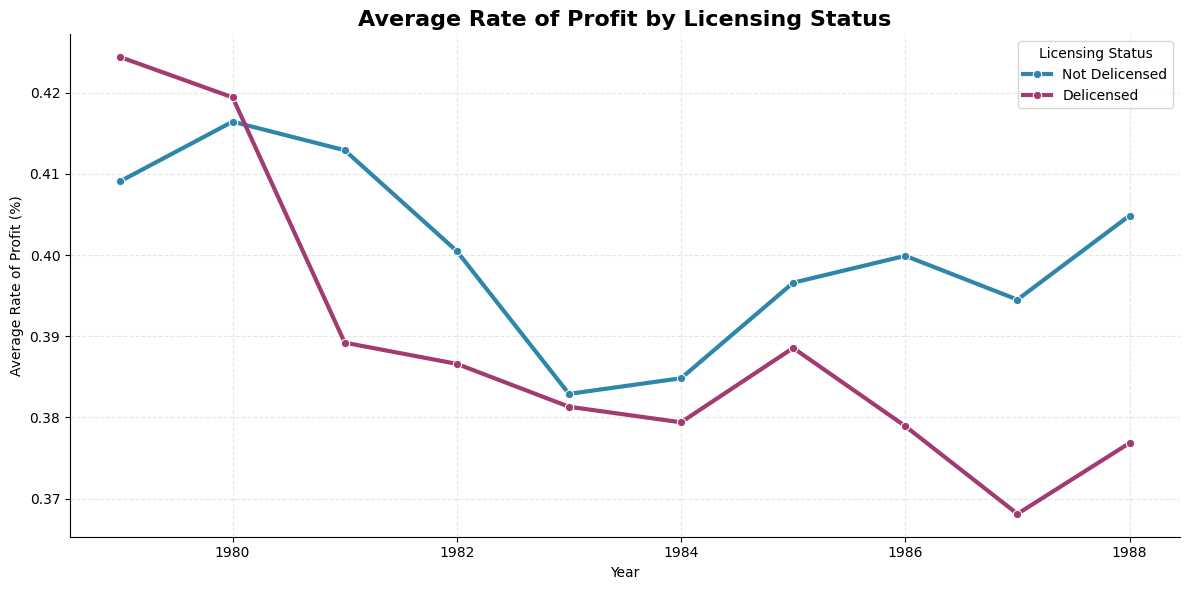

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

nic_codes_to_check = [
    274, 269, 268, 267, 266, 265, 264, 262, 261, 260, 259, 258, 257, 254, 250, 248, 247, 246, 245,
    243, 242, 241, 240, 236, 235, 234, 233, 232, 231, 230, 224, 218, 216, 215, 214, 213, 209, 208,
    205, 201, 200, 389, 387, 386, 385, 384, 383, 382, 381, 379, 378, 372, 370, 362, 361, 349, 345,
    340, 336, 335, 334, 333, 332, 329, 326, 325, 324, 317, 311, 303, 301, 296, 295, 291, 288, 287,
    284, 279, 277, 276, 275
]

df_filtered['nic_3digit'] = df_filtered['nic_code'].astype(str).str[:3]
nic_codes_str = [str(code) for code in nic_codes_to_check]
df_filtered['delicensed'] = df_filtered['nic_3digit'].isin(nic_codes_str).astype(int)

avg_profit_by_group = (
    df_filtered.groupby(['year', 'delicensed'])['rate_of_profit']
    .mean()
    .reset_index()
)

avg_profit_by_group['Licensing Status'] = avg_profit_by_group['delicensed'].map({1: 'Delicensed', 0: 'Not Delicensed'})

plt.figure(figsize=(12, 6))
sns.lineplot(data=avg_profit_by_group, x='year', y='rate_of_profit', hue='Licensing Status',
             palette=['#2E86AB', '#A23B72'], linewidth=3, marker='o')
plt.title('Average Rate of Profit by Licensing Status', fontsize=16, weight='bold')
plt.xlabel('Year')
plt.ylabel('Average Rate of Profit (%)')
plt.grid(True, linestyle='--', alpha=0.3)
sns.despine()
plt.tight_layout()
plt.show()